In [2]:
import pandas as pd
import evaluate
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

In [4]:
text_df = pd.read_csv("./df_file.csv") #./df_file.csv, /content/drive/MyDrive/df_file.csv

X = text_df['Text'].to_list()
y = text_df['Label'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Removing numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Joining tokens
    text = ' '.join(tokens)
    return text

quick brown fox jump lazi dog


In [4]:
def preprocess_function(examples):
    return tokenizer(examples["Text"], truncation=True)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 445/445 [00:00<00:00, 1250.64 examples/s]


In [5]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(X_train, truncation=True, padding=True)
#val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((
dict(train_encodings),
y_train
))

In [6]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
 
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

C:\Users\ROB7824\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ROB7824\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBer

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
 
model.fit(train_dataset.shuffle(1000).batch(16),
epochs=2,
batch_size=16,
#validation_data=val_dataset.shuffle(1000).batch(16),
callbacks=[early_stopping])

Epoch 1/2


112/112 [==============================] - 2174s 19s/step - loss: 0.4038 - accuracy: 0.9219
Epoch 2/2
112/112 [==============================] - 2024s 18s/step - loss: 0.0811 - accuracy: 0.9803


In [10]:
from tensorflow.keras.models import load_model
save_directory = "Models"
 
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('Models\\tokenizer_config.json',
 'Models\\special_tokens_map.json',
 'Models\\vocab.txt',
 'Models\\added_tokens.json')

In [11]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at Models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at Models and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
test_text = X_test[10]
test_text

'Blunkett row should end - Blair\r\n \r\n Prime Minister Tony Blair said it was time to draw a line under the controversy surrounding David Blunkett.\r\n \r\n The Tories and the Lib Dems have called for a second inquiry into the fast-tracking of a visa application for Mr Blunkett\'s ex-lover\'s nanny. Sir Alan Budd found a "chain of events" linked Mr Blunkett to Leoncia Casalme\'s indefinite leave to remain application. At the end of his Middle East trip, Mr Blair said he still admired Mr Blunkett and thought his integrity was intact.\r\n \r\n On Tuesday Sir Alan said the application for leave to remain in the UK made by Kimberly Quinn\'s nanny was processed in 52 days, 120 days faster than the average. But he could not find evidence to show whether Mr Blunkett\'s intervention was intended to give special help for his then lover\'s nanny - or if he was raising the case as an example of poor departmental performance. In his first comments since Sir Alan\'s announcement, Mr Blair told BB

In [20]:
def predict_category(text):
        predict_input = loaded_tokenizer.encode(text, truncation=True, padding=True, return_tensors="tf")
        output = loaded_model(predict_input)[0]
        prediction_value = tf.argmax(output, axis=1).numpy()[0]
        return prediction_value

In [21]:
y_pred = []
for text_ in X_test:
    y_pred.append(predict_category(text_))

In [25]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

# Additional evaluation metrics (classification report)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy on Test Set: 0.9752808988764045
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98        92
           1       1.00      0.98      0.99        98
           2       0.97      0.96      0.97        77
           3       0.95      1.00      0.97        76
           4       0.96      0.96      0.96       102

    accuracy                           0.98       445
   macro avg       0.97      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



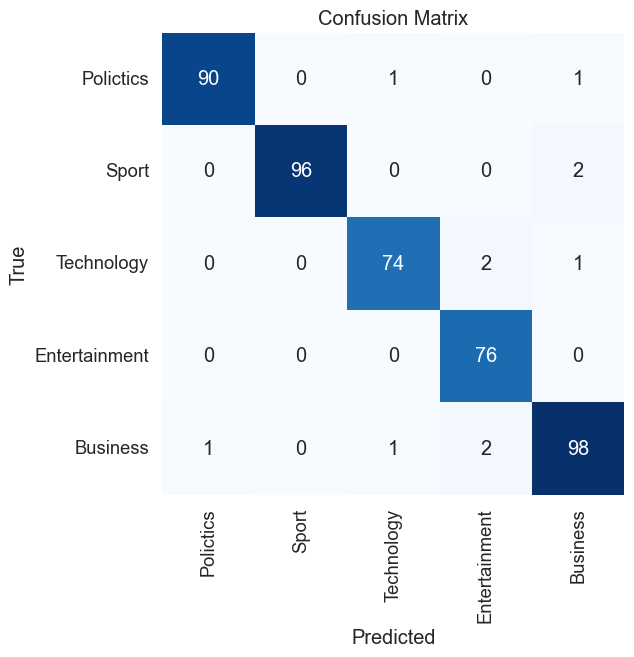

In [24]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
xticklabels=["Polictics", "Sport", "Technology", "Entertainment", "Business"], yticklabels=["Polictics", "Sport", "Technology", "Entertainment", "Business"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()